# Preprocessing

In [174]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

def load_ipeds_unis(fname='../data/IPEDS/hd2020.csv', encoding='cp1252'):
    return pd.read_csv(fname, encoding=encoding)

def filter_only_rs_and_las(unis):
    unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
    unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')
    return unis

def preprocess_names(unis):
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS'] =='Virginia Tech', 'INSTNM']                                            = 'Virginia Tech'
    unis.loc[unis['INSTNM'] =='University of Illinois Urbana-Champaign', 'INSTNM']                  = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM']             = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM']             = "St. John's College - NM"
    unis.loc[unis['INSTNM'] =="William & Mary", 'INSTNM']                                           = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM']      = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
    return unis

def fetch_rankings(fname='../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                   usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'], top=-1):
    
    rankings = pd.read_excel(fname,skiprows=skiprows, usecols=usecols)
    
    if top > -1:
        rankings = rankings[rankings['Rank']<=top]
        
    return rankings

unis     = load_ipeds_unis()
unis     = filter_only_rs_and_las(unis)
unis     = preprocess_names(unis)

rankings = fetch_rankings(top=100)

merged   = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')

print("Missing unis: %s " % set(rankings['Institution Name']).difference(merged['INSTNM']))

Missing unis: set() 


# CS vs. other majors

In [175]:

fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
# dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])


var, var_alt   = 'CTOTALW', 'CRACE16' 
women_abs      = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
women_abs      = pd.concat(women_abs, axis=1).transpose()

var, var_alt   = 'CBKAAT', 'CRACE18' 
black_abs      = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
black_abs      = pd.concat(black_abs, axis=1).transpose()

var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_abs   = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
hispanic_abs   = pd.concat(hispanic_abs, axis=1).transpose()

var, var_alt   = 'CAIANT', 'CRACE19'
natives_abs    = [df.groupby('CS').apply(lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) for year, df in cs_and_noncs]
natives_abs    = pd.concat(natives_abs, axis=1).transpose()

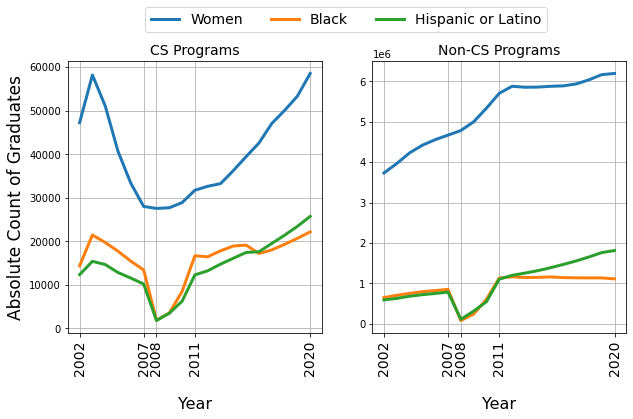

In [250]:
fig, axs       = plt.subplots(1, 2, figsize=(10,5))

_ = [axs[0].plot(df, linewidth=3) for df in [women_abs[True], black_abs[True], hispanic_abs[True]]]
# axs[0].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[0].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[0].set_title('CS Programs', color='black', fontsize=14);
# axs[0].legend(['Women', 'Black', 'Hispanic', 'Native American']);

_ = [axs[1].plot(df, linewidth=3) for df in [women_abs[False], black_abs[False], hispanic_abs[False]]]
# axs[1].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[1].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[1].set_title('Non-CS Programs', color='black', fontsize=14);
# axs[1].legend(['Women', 'Black', 'Hispanic', 'Native American']);

# handles, labels = axs[0].get_legend_handles_labels()
fig.legend(['Women', 'Black', 'Hispanic or Latino'], ncol=4, fontsize=14, bbox_to_anchor=(0.8, 1.05))

axs[0].set_ylabel('Absolute Count of Graduates', color='black', fontsize=17);
axs[0].set_xlabel('\nYear', color='black', fontsize=16);
axs[1].set_xlabel('\nYear', color='black', fontsize=16);

axs[0].grid();
axs[1].grid();


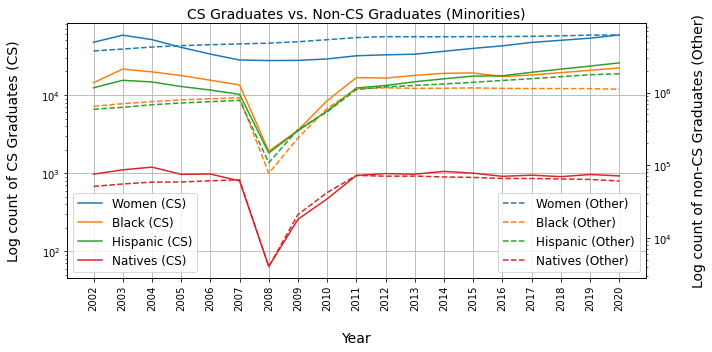

In [234]:

fig, ax1 = plt.subplots(figsize=(10,5))
ax2      = ax1.twinx()

_ = [ax1.plot(df, label=label) for df, label in [(women_abs[True],   'Women (CS)'),    (black_abs[True],   'Black (CS)'),\
                                                 (hispanic_abs[True],'Hispanic (CS)'), (natives_abs[True], 'Natives (CS)')]]

_ = [ax2.plot(df, label=label, linestyle='--') for df, label in [(women_abs[False], 'Women (Other)'),       (black_abs[False], 'Black (Other)'),\
                                                                 (hispanic_abs[False], 'Hispanic (Other)'), (natives_abs[False], 'Natives (Other)')]]

ax1.set_xticks(range(len(years)), sorted(years), rotation=90);
ax2.set_xticks(range(len(years)), sorted(years), rotation=90);

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

ax1.set_yscale('log');
ax2.set_yscale('log');
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='lower right', fontsize=12)

ax1.set_ylabel('Log count of CS Graduates (CS)\n', color='black', fontsize=14)
ax2.set_ylabel('\nLog count of non-CS Graduates (Other)', color='black', fontsize=14)

ax1.set_xlabel('\nYear', fontsize=14);
ax2.set_xlabel('Year', fontsize=14);
ax1.grid();
ax2.grid();

plt.title('CS Graduates vs. Non-CS Graduates (Minorities)', fontsize=14);
plt.tight_layout();
plt.grid();

# Percentages: 

In [224]:
fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
# dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])

In [225]:

var, var_alt   = 'CTOTALW', 'CRACE16' 
women_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())      if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()   if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]


var, var_alt   = 'CAIANT', 'CRACE19'
natives_pct      = [df.groupby('CS').apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum())\
                    for _, df in cs_and_noncs]

women_pct      = pd.concat(women_pct, axis=1).transpose()
black_pct      = pd.concat(black_pct, axis=1).transpose()
hispanic_pct   = pd.concat(hispanic_pct, axis=1).transpose()
natives_pct    = pd.concat(natives_pct, axis=1).transpose()

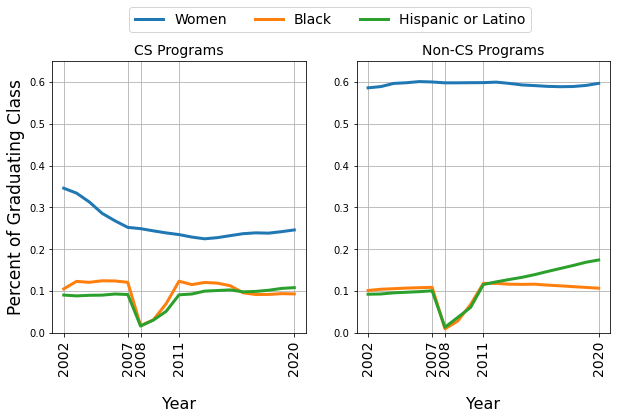

In [251]:
fig, axs       = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(women_pct[True], linewidth=3)
axs[0].plot(black_pct[True], linewidth=3)
axs[0].plot(hispanic_pct[True], linewidth=3)
# axs[0].plot(natives_pct[True])
axs[0].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[0].set_title('CS Programs', color='black', fontsize=14);
# axs[0].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[1].plot(women_pct[False], linewidth=3)
axs[1].plot(black_pct[False], linewidth=3)
axs[1].plot(hispanic_pct[False], linewidth=3)
# axs[1].plot(natives_pct[False])
axs[1].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[1].set_title('Non-CS Programs', color='black', fontsize=14);
# axs[1].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[0].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[1].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[0].grid();
axs[1].grid();
fig.legend(['Women', 'Black', 'Hispanic or Latino'], ncol=4, fontsize=14, bbox_to_anchor=(0.8, 1.05))

axs[0].set_ylabel('Percent of Graduating Class', color='black', fontsize=17);
axs[0].set_xlabel('\nYear', color='black', fontsize=16);
axs[1].set_xlabel('\nYear', color='black', fontsize=16);

axs[0].set_ylim(0, 0.65);
axs[1].set_ylim(0, 0.65);


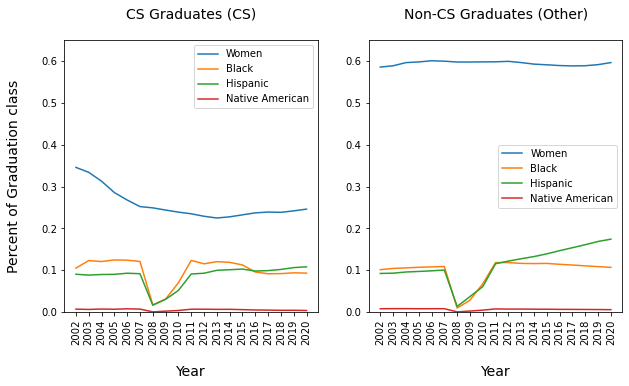

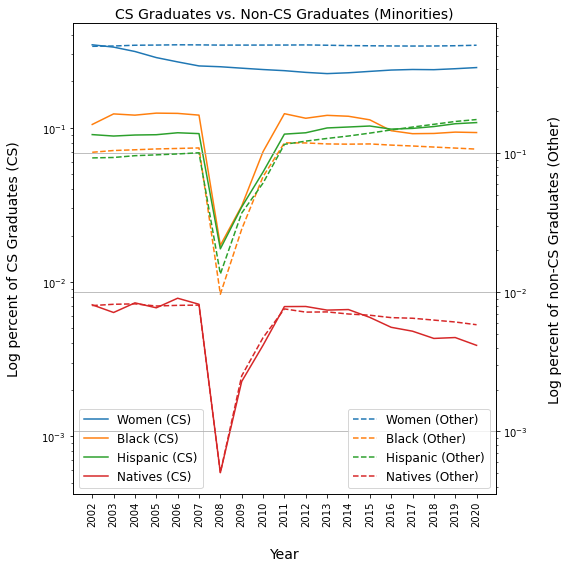

In [226]:

fig, ax1 = plt.subplots(figsize=(8,8))
ax2      = ax1.twinx()

ax1.plot(women_pct[True],     label='Women (CS)')
ax1.plot(black_pct[True],     label='Black (CS)')
ax1.plot(hispanic_pct[True],  label='Hispanic (CS)')
ax1.plot(natives_pct[True],   label='Natives (CS)')

ax2.plot(women_pct[False],    label='Women (Other)',    linestyle='--')
ax2.plot(black_pct[False],    label='Black (Other)',    linestyle='--')
ax2.plot(hispanic_pct[False], label='Hispanic (Other)', linestyle='--')
ax2.plot(natives_pct[False],  label='Natives (Other)',  linestyle='--')

ax1.set_xticks(range(len(years)), sorted(years), rotation=90);
ax2.set_xticks(range(len(years)), sorted(years), rotation=90);

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

ax1.set_yscale('log');
ax2.set_yscale('log');
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='lower right', fontsize=12)

ax1.set_ylabel('Log percent of CS Graduates (CS)\n', color='black', fontsize=14)
ax2.set_ylabel('\nLog percent of non-CS Graduates (Other)', color='black', fontsize=14)

ax1.set_xlabel('\nYear', fontsize=14);
ax2.set_xlabel('Year', fontsize=14);

plt.title('CS Graduates vs. Non-CS Graduates (Minorities)', fontsize=14);
plt.tight_layout();
plt.grid();

In [ ]:
years = list(cs_results.keys())
commonids = set(cs_results[years[0]].index)
for year in years[1:]:
    commonids = commonids.intersection(set(cs_results[year].index))
    
all_years_cs = pd.concat([cs_results[year].loc[commonids] for year in years], axis=1)
merged_cs = pd.merge(unis2, all_years_cs, left_on='UNITID', right_index=True)

In [ ]:
years = list(non_cs_results.keys())
commonids = set(non_cs_results[years[0]].index)
for year in years[1:]:
    commonids = commonids.intersection(set(non_cs_results[year].index))
    
all_years_noncs = pd.concat([non_cs_results[year].loc[commonids] for year in years], axis=1)
merged_noncs = pd.merge(unis2, all_years_noncs, left_on='UNITID', right_index=True)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# axs = [x for ax in axs for x in ax]

for i, (label, var, var_alt) in enumerate([women, black, hispanic, natives]):
    
    years_sorted = sorted([col for col in merged_cs.columns if label in col])
    
    '''Filter for non-HBCUs and mixed gender schools'''
    
    noncs_means = merged_noncs.mean()[years_sorted]
    noncs_sems  = merged_noncs.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=noncs_means, yerr=noncs_sems)

    cs_means = merged_cs.mean()[years_sorted]
    cs_sems  = merged_cs.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=cs_means, yerr=cs_sems)

    # axs[i].set_xticks(axs[i].xticks(), [x.split('_')[1] for x in years_sorted])    
    axs[i].tick_params(labelrotation=90)
    axs[i].set_title(label)

    axs[i].legend(['Non-CS', 'CS'])

fig.suptitle('CS/IT Graduates, from minority groups, over time [WITH HBCU and All-Women Colleges]');

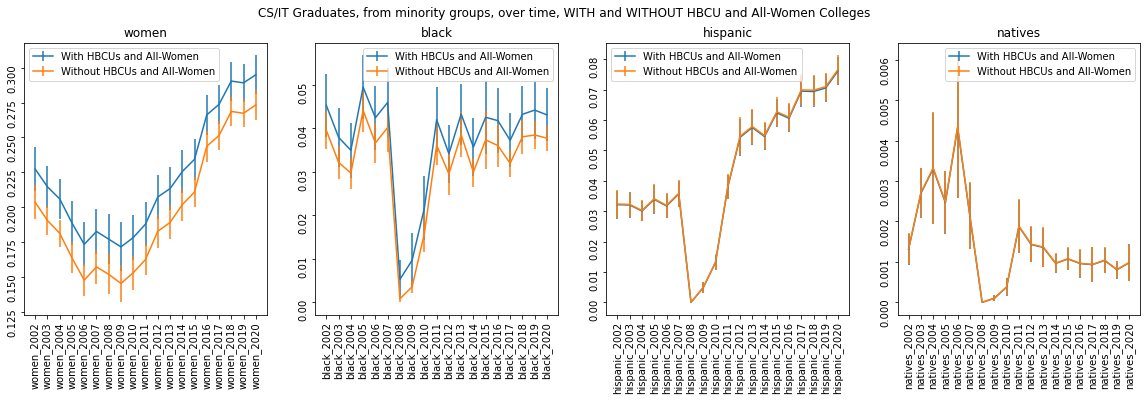

In [177]:


fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# axs = [x for ax in axs for x in ax]

for i, (label, var, var_alt) in enumerate([women, black, hispanic, natives]):
    
    years_sorted = sorted([col for col in merged_cs.columns if label in col])
    
    '''Filter for non-HBCUs and mixed gender schools'''
    
    cs_means = merged.mean()[years_sorted]
    cs_sems  = merged.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=cs_means, yerr=cs_sems)

    filtered = merged[merged['HBCU']==2]
    filtered = filtered[filtered.apply(lambda x: np.all(x[years_sorted]==1)==False, axis=1)]
    # filtered = merged

    cs_means = filtered.mean()[years_sorted]
    cs_sems  = filtered.sem()[years_sorted]

    axs[i].errorbar(x=years_sorted, y=cs_means, yerr=cs_sems)

    # axs[i].set_xticks(axs[i].xticks(), [x.split('_')[1] for x in years_sorted])    
    axs[i].tick_params(labelrotation=90)
    axs[i].set_title(label)

    axs[i].legend(['With HBCUs and All-Women', 'Without HBCUs and All-Women'])

fig.suptitle('CS/IT Graduates, from minority groups, over time, WITH and WITHOUT HBCU and All-Women Colleges');

# Regional Patterns

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


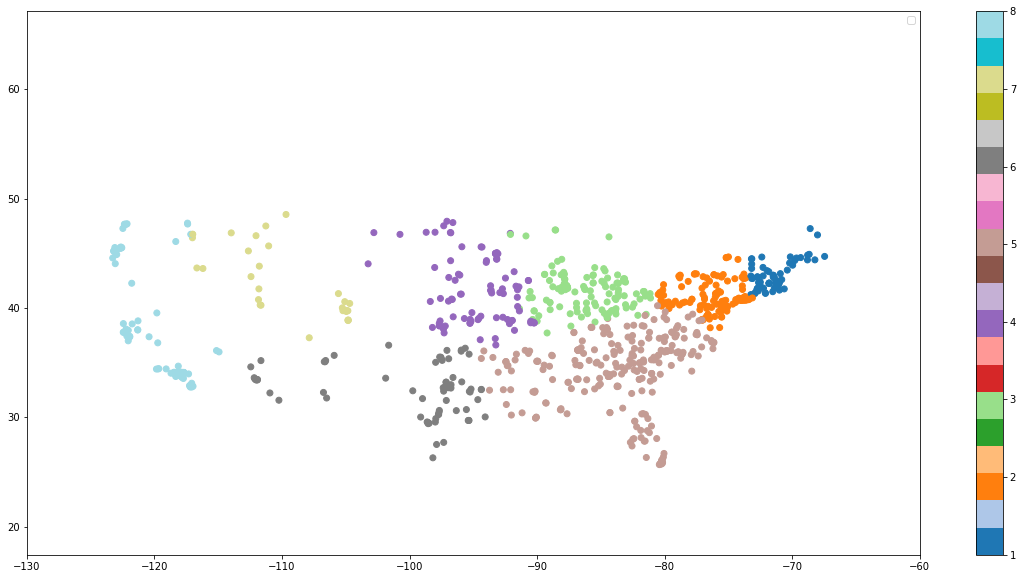

In [438]:
plt.figure(figsize=(20, 10))
filtered = unis[unis['OBEREG'].apply(lambda x: x in range(1, 9))]
plt.scatter(filtered['LONGITUD'], filtered['LATITUDE'], c=filtered['OBEREG'], cmap='tab20')
plt.colorbar()
plt.xlim((-130, -60))


plt.legend()

In [172]:

fnames         = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
# dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])

cs_and_noncs   = [(year, df.rename(columns={col: col.upper().strip() for col in df.columns})) for year, df in cs_and_noncs]
cs_and_noncs   = [(year, pd.merge(unis[['UNITID', 'OBEREG']], df, on='UNITID')) for year, df in cs_and_noncs]

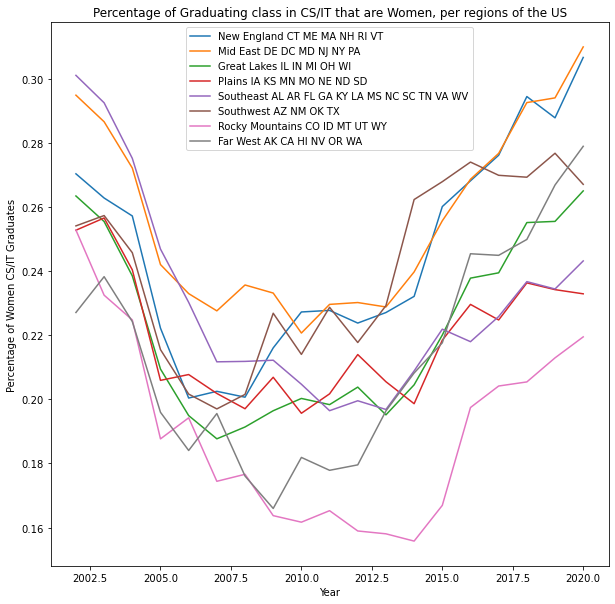

In [17]:
var, var_alt   = 'CTOTALW', 'CRACE16' 
women_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())      if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()   if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(women_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]
cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]

plt.figure(figsize=(10, 10))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

plt.xlabel('Year');
plt.ylabel('Percentage of Women CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Women, per regions of the US');

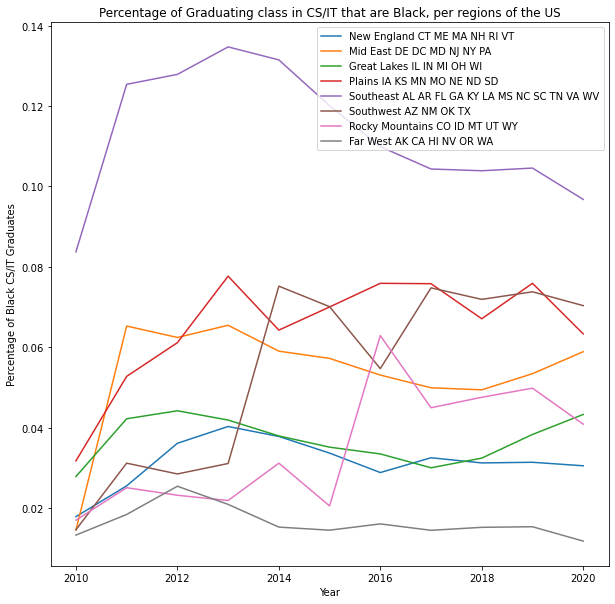

In [171]:
var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(black_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]

cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]


plt.figure(figsize=(10, 10))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

# plt.yscale('log')
plt.xlabel('Year');
plt.ylabel('Percentage of Black CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Black, per regions of the US');

In [162]:
years = list(range(2010, 2021))
cs[years] = cs[years]*100


In [163]:
cs

,CS,OBEREG,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
11,True,1,0.023742,0.026439,0.021538,0.028571,0.03147,0.029922,0.000854,0.001249,...,2.552204,3.611012,4.02859,3.780929,3.367003,2.882686,3.250996,3.122252,3.13847,3.051334
12,True,2,0.074166,0.074125,0.067859,0.070494,0.071812,0.074439,0.0,0.007868,...,6.527312,6.243545,6.546744,5.902936,5.722606,5.307907,4.991522,4.940895,5.342292,5.889307
13,True,3,0.041451,0.050659,0.052639,0.057552,0.05356,0.048971,0.002383,0.016823,...,4.220888,4.419806,4.188482,3.793607,3.514485,3.346239,3.001592,3.241741,3.830206,4.327869
14,True,4,0.036294,0.041088,0.039628,0.037935,0.046426,0.054713,0.001499,0.02201,...,5.275862,6.113821,7.768493,6.426056,7.001843,7.590336,7.581227,6.708861,7.590813,6.332538
15,True,5,0.141434,0.153924,0.160366,0.15714,0.147002,0.139951,0.02226,0.037858,...,12.541124,12.788589,13.472117,13.149367,12.00922,10.990853,10.434729,10.391096,10.457765,9.678352
16,True,6,0.031537,0.032008,0.032505,0.033501,0.02876,0.035253,0.000775,0.001947,...,3.116531,2.847782,3.108203,7.51992,7.010135,5.468063,7.478039,7.19091,7.379774,7.035141
17,True,7,0.022162,0.024691,0.022269,0.028692,0.026236,0.032102,0.005253,0.004755,...,2.505967,2.317881,2.186879,3.115664,2.052672,6.29055,4.495229,4.755309,4.981826,4.086064
18,True,8,0.019837,0.020875,0.018326,0.014091,0.013843,0.023757,0.0,0.00278,...,1.84002,2.542373,2.090813,1.525553,1.448809,1.605178,1.445967,1.519875,1.534636,1.177543


In [164]:
cs[years] = cs[years].apply(lambda x: x-x.shift(1), axis=1)

(2010.0, 2021.0)

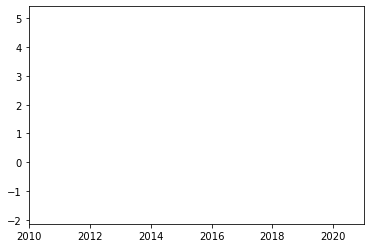

In [83]:
var, var_alt   = 'CBKAAT', 'CRACE18' 
black_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x: \
                    (x[var].sum()) if var in df.columns else x[var_alt].sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(black_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]

cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]

,2012,2013,2014,2015,2016,2017,2018,2019,2020
11,NaN,22.772277,9.677419,10.294118,5.333333,29.113924,4.411765,9.389671,9.442060
12,NaN,13.834586,2.509908,8.891753,3.431953,7.780320,18.471338,16.845878,26.073620
13,NaN,-1.030928,-0.694444,9.440559,15.974441,3.856749,11.405836,29.761905,21.100917
14,NaN,33.510638,-12.749004,21.461187,33.458647,12.394366,-7.017544,25.606469,-14.592275
15,NaN,18.052930,7.205765,12.845407,4.169424,7.052097,18.575668,10.110110,6.545455
16,NaN,17.699115,467.669173,-1.059603,-8.433735,45.614035,-3.413655,3.846154,0.400400
17,NaN,4.761905,65.909091,-27.397260,320.754717,-19.730942,15.083799,13.106796,-11.158798
18,NaN,-10.810811,-19.191919,12.500000,37.777778,7.258065,17.293233,14.743590,-13.407821


In [103]:
a.pct_change?

Signature: a.pct_change(periods=1, fill_method='pad', limit=None, freq=None, **kwargs) -> 'NDFrameT'
Docstring:
Percentage change between the current and a prior element.

Computes the percentage change from the immediately previous row by
default. This is useful in comparing the percentage of change in a time
series of elements.

Parameters
----------
periods : int, default 1
    Periods to shift for forming percent change.
fill_method : str, default 'pad'
    How to handle NAs before computing percent changes.
limit : int, default None
    The number of consecutive NAs to fill before stopping.
freq : DateOffset, timedelta, or str, optional
    Increment to use from time series API (e.g. 'M' or BDay()).
**kwargs
    Additional keyword arguments are passed into
    `DataFrame.shift` or `Series.shift`.

Returns
-------
chg : Series or DataFrame
    The same type as the calling object.

See Also
--------
Series.diff : Compute the difference of two elements in a Series.
DataFrame.diff : C

In [102]:
years = range(2012, 2021)
a = cs[years].apply(lambda x: x.pct_change(), axis=1)
a.index = ['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA']
import seaborn as sns
a.loc['Southeast AL AR FL GA KY LA MS NC SC TN VA WV']
# plt.yticks(range(a.shape[0]), a.index)
# plt.xticks(range(len(years)), years)
# plt.colorbar()

2012         NaN
2013    0.180529
2014    0.072058
2015    0.128454
2016    0.041694
2017    0.070521
2018    0.185757
2019    0.101101
2020    0.065455
Name: Southeast AL AR FL GA KY LA MS NC SC TN VA WV, dtype: float64

In [93]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the *dpi* of the figure. This can lead to aliasing artifacts when
    the image is resampled because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled via the *interpolation* parameter
    and/or 

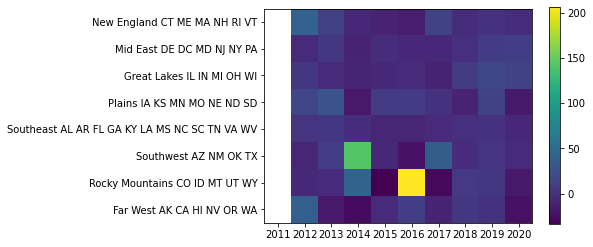

In [76]:



plt.figure(figsize=(10, 10))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

plt.xlabel('Year');
plt.ylabel('Percentage of Black CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Black, per regions of the US');

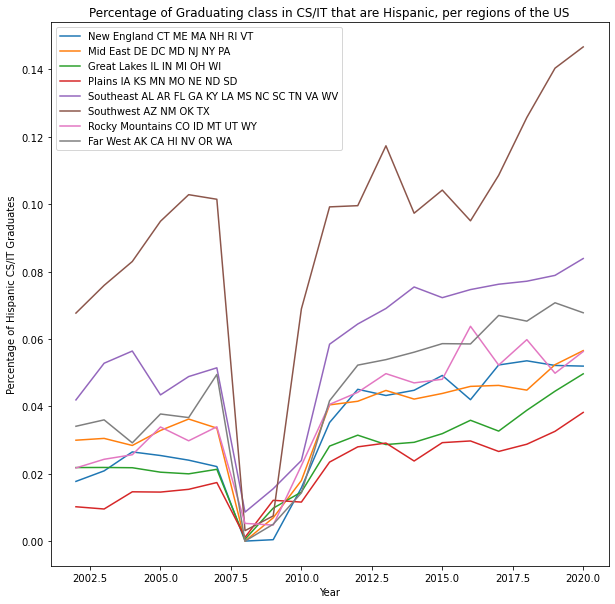

In [21]:
var, var_alt   = 'CHISPT', 'CRACE21'
hispanic_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(hispanic_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]

cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]


plt.figure(figsize=(10, 10))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

plt.xlabel('Year');
plt.ylabel('Percentage of Hispanic CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Hispanic, per regions of the US');

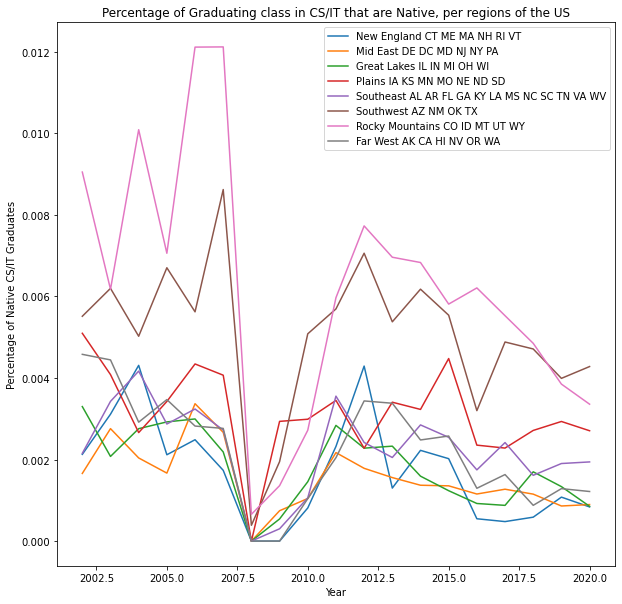

In [22]:
var, var_alt   = 'CAIANT', 'CRACE19'
natives_pct      = [df.groupby(['CS', 'OBEREG']).apply(lambda x:\
                       (x[var].sum()/x['CTOTALT'].sum())       if var in df.columns       else\
                        x[var_alt].sum()/x['CRACE24'].sum()    if 'CRACE24' in df.columns else\
                        x[var_alt].sum()/(x['CRACE15']+x['CRACE16']).sum()).reset_index().rename(columns={0:year})\
                    for year, df in cs_and_noncs]

concatentated = pd.concat(natives_pct, axis=1)
concatentated = concatentated.T.drop_duplicates().T

cs = concatentated[concatentated['CS']==True]

cs = cs[cs['OBEREG'].apply(lambda x: x in range(1, 9))]


plt.figure(figsize=(10, 10))
cs.apply(lambda x: plt.plot(x[years].sort_index(), label=x['OBEREG']), axis=1);
plt.legend(['New England CT ME MA NH RI VT',
            'Mid East DE DC MD NJ NY PA',
            'Great Lakes IL IN MI OH WI',
            'Plains IA KS MN MO NE ND SD',
            'Southeast AL AR FL GA KY LA MS NC SC TN VA WV',
            'Southwest AZ NM OK TX',
            'Rocky Mountains CO ID MT UT WY',
            'Far West AK CA HI NV OR WA'])

plt.xlabel('Year');
plt.ylabel('Percentage of Native CS/IT Graduates');
plt.title('Percentage of Graduating class in CS/IT that are Native, per regions of the US');


In [38]:
cs[list(range(2002, 2020))].replace(np.inf, 0)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
11,0.002126,0.00311,0.004308,0.002116,0.002484,0.001735,0.0,0.0,0.000812,0.00232,0.00429,0.0013,0.002224,0.00202,0.000547,0.000478,0.000586,0.001078
12,0.001658,0.002757,0.002038,0.001667,0.003368,0.002666,0.0,0.000744,0.001044,0.002169,0.001784,0.001557,0.001369,0.001354,0.001154,0.001272,0.001151,0.00086
13,0.003297,0.002075,0.002756,0.002921,0.002994,0.002185,0.0,0.000543,0.001455,0.002836,0.002278,0.002327,0.001592,0.001235,0.000922,0.000876,0.001698,0.001335
14,0.005094,0.004082,0.00266,0.003423,0.004342,0.004067,0.0,0.002935,0.002987,0.003448,0.002276,0.003405,0.003228,0.004475,0.002352,0.00228,0.002712,0.002932
15,0.002152,0.003425,0.004167,0.00287,0.003238,0.002722,0.0,0.000302,0.00106,0.003553,0.002418,0.002049,0.002848,0.002543,0.001746,0.002415,0.001612,0.001901
16,0.005511,0.006195,0.005021,0.0067,0.00562,0.008617,0.000388,0.001947,0.005081,0.005691,0.007056,0.005375,0.006175,0.005537,0.003198,0.00488,0.004709,0.003989
17,0.009046,0.006173,0.010084,0.007056,0.012109,0.012114,0.000657,0.001359,0.002717,0.005967,0.007726,0.006958,0.006829,0.005809,0.006206,0.005525,0.004848,0.003849
18,0.004578,0.004441,0.002915,0.003468,0.00282,0.002762,0.0,0.0,0.001041,0.002044,0.003436,0.003379,0.002479,0.002576,0.001294,0.001631,0.000877,0.001286


In [47]:
cs[list(range(2002, 2020))].apply(lambda x: x.pct_change(), axis=1).replace(np.inf, 0).replace(np.nan, 0)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
11,0.0,0.462934,0.384923,-0.508692,0.173913,-0.301821,-1.000000,0.000000,0.000000,1.858469,0.849124,-0.697098,0.711426,-0.091667,-0.729064,-0.126534,0.226424,0.837823
12,0.0,0.662302,-0.260700,-0.182290,1.020738,-0.208388,-1.000000,0.000000,0.403354,1.076790,-0.177636,-0.127353,-0.120417,-0.010791,-0.148081,0.102117,-0.094848,-0.252598
13,0.0,-0.370623,0.328048,0.060035,0.024850,-0.270344,-1.000000,0.000000,1.681705,0.948803,-0.196716,0.021369,-0.315957,-0.224034,-0.253654,-0.049936,0.938870,-0.213629
14,0.0,-0.198724,-0.348404,0.286937,0.268593,-0.063444,-1.000000,0.000000,0.017924,0.154310,-0.339837,0.495556,-0.051937,0.386394,-0.474412,-0.030556,0.189647,0.080958
15,0.0,0.591905,0.216544,-0.311295,0.128351,-0.159438,-1.000000,0.000000,2.513780,2.352095,-0.319607,-0.152265,0.389617,-0.106945,-0.313617,0.383500,-0.332453,0.179366
16,0.0,0.124075,-0.189504,0.334391,-0.161240,0.533375,-0.955021,4.024343,1.609082,0.120071,0.239919,-0.238273,0.148874,-0.103398,-0.422463,0.526175,-0.035044,-0.152925
17,0.0,-0.317593,0.633613,-0.300329,0.716246,0.000404,-0.945798,1.069293,1.000000,1.195704,0.294923,-0.099404,-0.018596,-0.149279,0.068246,-0.109744,-0.122576,-0.206084
18,0.0,-0.029783,-0.343586,0.189681,-0.187019,-0.020342,-1.000000,0.000000,0.000000,0.964222,0.680457,-0.016459,-0.266364,0.038982,-0.497411,0.259785,-0.462315,0.466621
